In [9]:
import sys
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.evapo import *
import geopandas as gpd
import tarfile
from rasterio.transform import from_bounds
import gzip
import shutil

workhorse = True

if workhorse:
    origin = 'Aldhani/eoagritwin/'
else:
    origin = ''

utm_to_epsg = {
    '28': 32628,  # Western Portugal, Azores
    '29': 32629,  # Western Spain, Portugal
    '30': 32630,  # Spain, France, UK
    '31': 32631,  # France, Benelux, Germany, Western Norway
    '32': 32632,  # Germany, Denmark, Switzerland, Italy, Austria
    '33': 32633,  # Central Europe: Poland, Czechia, Hungary, Croatia, Sweden, Norway
    '34': 32634,  # Eastern Europe: Finland, Baltic States, Romania
    '35': 32635,  # Western Russia, Ukraine
    '36': 32636,  # Russia, Black Sea region
}

In [13]:
#### get path and rows of scenes that have data for the chosen AOI (e.g. Brandenburg)

# load shapefiles and 
ger = gpd.read_file(f'/data/{origin}misc/gadm41_DEU_shp/gadm41_DEU_1.shp')

state = 'Brandenburg'
aoi = ger[ger['NAME_1'] == state]

orbits = gpd.read_file(f'/data/{origin}misc/WRS2_descending_0/WRS2_descending.shp')
# check projections
if aoi.crs != orbits.crs:
    aoi = aoi.to_crs(orbits.crs)

# find overlapping paths/rows
#intersecting = orbits[orbits.intersects(aoi.unary_union)]
intersecting = gpd.sjoin(orbits, aoi, how="inner", predicate="intersects")
path_rows = [[p, r] for p, r in zip(intersecting['PATH'], intersecting['ROW'])]
# make sure, paths and rows have the correct format
path_rows = [f'{str(p).zfill(3)}{str(r).zfill(3)}' for p, r in path_rows]

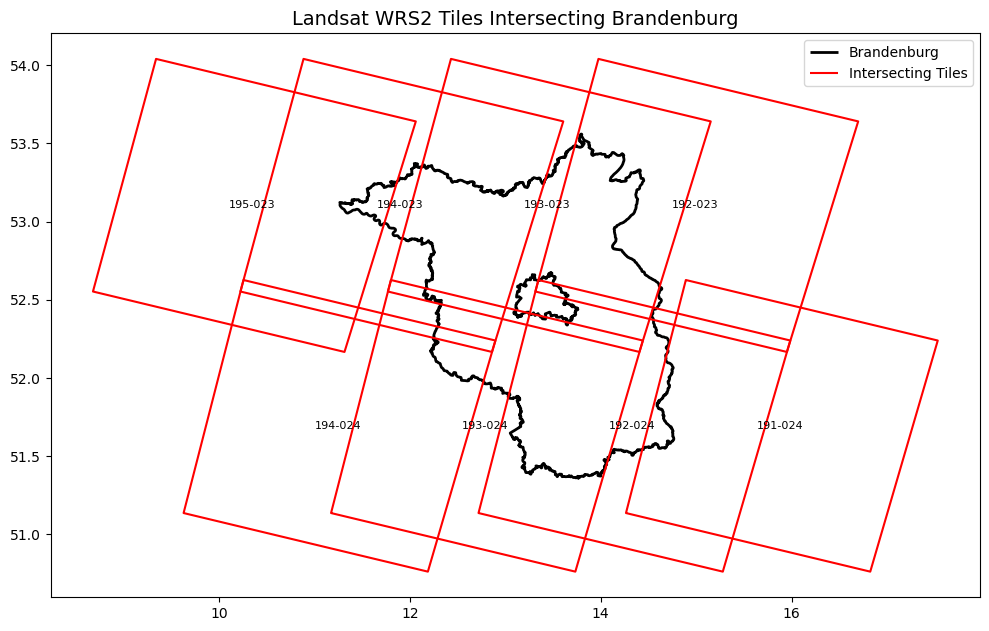

In [14]:
import matplotlib.pyplot as plt

# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the AOI (Brandenburg)
aoi.boundary.plot(ax=ax, color='black', linewidth=2, label='Brandenburg')

# Plot all orbit tiles in light grey (optional for context)
#orbits.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5, label='All WRS2 tiles')

# Highlight the intersecting tiles
intersecting.boundary.plot(ax=ax, color='red', linewidth=1.5, label='Intersecting Tiles')

# Optionally label each tile with PATH-ROW
for idx, row in intersecting.iterrows():
    label = f"{int(row['PATH']):03d}-{int(row['ROW']):03d}"
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, label, fontsize=8, ha='center', va='center')

# Title and legend
ax.set_title(f'Landsat WRS2 Tiles Intersecting {state}', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# get all paths from downloaded products --> subsetted to paths and rows
landsat_files = getFilelist(f'/data/{origin}et/Landsat/raw/', '.tar.gz', deep=True)

# create a look-up dictionary for time subsets
lookUp = LandsatETFileManager(landsat_files)

#### do the compositing monthly
year = 2021
month = 6

# check if temp_folder is empty and delete everything if not
tempF = f'/data/{origin}et/Landsat/extracts/'
if len(getFilelist(tempF, '.nc')) > 0:
    for end in ['.nc', '.xml', '.txt']:
        for file in getFilelist(tempF, end):
            os.remove(file)
    print('kill complete')


# subset data for year and month and extract
year_month = lookUp.get_by_year_and_month(year, month)
year_month_path_row = [scene for scene in year_month for pr in path_rows if pr in scene]

dir_for_corrupt_files = f'/data/{origin}et/Landsat/raw/bad_files/'
os.makedirs(dir_for_corrupt_files, exist_ok=True)

for landsat_file in year_month_path_row:
    try:
        with tarfile.open(landsat_file, 'r:gz') as tar:
            tar.extractall(tempF)
    except (tarfile.ReadError, gzip.BadGzipFile, OSError):
        basename = os.path.basename(landsat_file)
        corrupt_path = os.path.join(dir_for_corrupt_files, basename)
        shutil.move(landsat_file, corrupt_path)
    

ReadError: not a gzip file

In [8]:
os.path.basename(landsat_file)

'LC081960242021060202T1-SC20250407204914.tar.gz'

In [4]:
# List of file paths
files_nc = getFilelist(f'/data/{origin}et/Landsat/extracts/', '.nc')
files_xml = getFilelist(f'/data/{origin}et/Landsat/extracts/', '.xml')
datasets = []

bound_coords = {
    'UTM': [],
    'UL_X': [],
    'UL_Y': [],
    'LR_X': [],
    'LR_Y': []
}

# loop over all extracted files and give spatial ref 
for f_nc in files_nc:

    ds = xr.open_dataset(f_nc)
    da = ds['ETA']
    if len(np.unique(da.values)) == 1:
        continue
    # find UL corner coordinates to find the most outer one for common grid
    utm_zone, ul_x, ul_y, lr_x, lr_y = get_UTM_zone_and_corners_from_xml(f_nc, files_xml)
   
    da.rio.set_spatial_dims(x_dim="XDim_ETA", y_dim="YDim_ETA", inplace=True)
    da.rio.write_crs(f'EPSG:{utm_to_epsg[utm_zone]}', inplace=True)
    datasets.append(da)

In [11]:
warped_arrays = []

for counti, xr_raster in enumerate(datasets):
    src_ds = xarray_to_gdal_mem(xr_raster)
    warped_ds = warp_to_template(src_ds, f'/data/{origin}et/Auxiliary/Landsat_GER_mask/states/{state}.tif')
    arr = warped_ds.GetRasterBand(1).ReadAsArray()
    warped_arrays.append(arr)

In [12]:
warped_stack = np.dstack(warped_arrays)
warped_stack[warped_stack == 0.0] = np.nan
median  = np.nanmedian(warped_stack, axis=2)

/tmp/ipykernel_4161175/330774565.py:3: RuntimeWarning: All-NaN slice encountered
  median  = np.nanmedian(warped_stack, axis=2)


In [ ]:
# mask output
mask_ds = gdal.Open(f'/data/{origin}et/Auxiliary/Landsat_GER_mask/states/{state}.tif')
mask_arr = mask_ds.GetRasterBand(1).ReadAsArray()
median_masked = median * mask_arr

In [17]:
makeTif_np_to_matching_tif(median_masked, 
                            f'/data/{origin}et/Auxiliary/Landsat_GER_mask/states/{state}.tif',
                           f'/data/{origin}et/Landsat/composites/{year}_{month:02d}_median_masked.tif', 0, gdalType=gdal.GDT_Float32)